# Import libraries

In [1]:
# Common
from common import data_paths as dp
from common import bigram_processing as bp
from common import globals as gl
from common import data_processing as dproc
from common import data_loading as dl

# General
import numpy as np
import pandas as pd
import scapy.all as scapy
import pickle
import torch
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from time import time
from sklearn.metrics import roc_auc_score, roc_curve, auc
import re

# Load the attack file used for training

In [2]:
data_attack = dl.load_ngram(dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.ATTACK_PATH + 'light_audio.pcap')
print(data_attack[:10])
print(len(data_attack))

['200.20.168.192.in-add.', '200.20.168.192.in-addr.arpa.', '200.20.168.192.in-add.', '200.20.168.192.in-addr.arpa.', '252.0.0.224.in-addr.a.', '252.0.0.224.in-addr.arpa.', '252.0.0.224.in-addr.arpa.', '252.0.0.224.in-addr.a.', '3.0.0.0.1.0.0.0.0.0.0.', '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.']
53328


In [3]:
data_attack2 = dl.load_ngram(dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.ATTACK_PATH + 'light_compressed.pcap')
print(data_attack2[:10])
print(len(data_attack2))

['2.20.168.192.in-addr.arpa.', '2.20.168.192.in-addr..', '3.0.0.0.1.0.0.0.0.0.0.', '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.', '3.0.0.0.1.0.0.0.0.0.0.', '3.0.0.0.1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.', '252.0.0.224.in-addr.a.', '252.0.0.224.in-addr.arpa.', '252.0.0.224.in-addr.a.', '252.0.0.224.in-addr.arpa.']
38420


In [4]:
data_benign = dl.load_ngram(dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.BENIGN_PATH + 'benign.pcap')
print(data_benign[:10])
print(len(data_benign))

['100.20.168.192.in-add.', '100.20.168.192.in-addr.arpa.', '2.20.168.192.in-addr..', '2.20.168.192.in-addr.arpa.', '2.20.168.192.in-addr..', '2.20.168.192.in-addr.arpa.', '150.20.168.192.in-add.', '150.20.168.192.in-addr.arpa.', '150.20.168.192.in-add.', '150.20.168.192.in-addr.arpa.']
101588


# Load benign domains

In [5]:
benign_domains_file_3 = dp.PCAP_PATH + dp.ATTACK_LIGHT_PATH + dp.BENIGN_PATH + 'domains.txt'

benign_domains = []

with open(benign_domains_file_3) as f:
    for line in f:
        # benign_domains.append('.'.join(line.strip().split('.')[:-1]))
        benign_domains.append(line.strip())
print(benign_domains[:10])
benign_domains = set(benign_domains)

['dvg-gestalt.de', 'dxgalaxy.com', 'e2n.de', 'easycredit-bbl.de', 'eatbu.com', 'ecomedes.com', 'edels-stube.eu', 'edmboost.org', 'edmfull.com', 'einfachflirts.com']


In [6]:
sldstlds = pd.read_csv(dp.MISC_PATH + 'SLDs.csv', header=None, names=['TLD', 'SLD'], sep=',')['SLD']
slds = []
for s in sldstlds:
    spl = s.split('.')[-2]
    if spl != '':
        slds.append(spl)
print(slds[:10])
slds = set(slds)

benign_dataset_domains = []
for bdom in benign_domains:
    benign_dataset_domains.append(dproc.get_domain_name(bdom, slds))
    
print(benign_dataset_domains[:10])
benign_dataset_domains = set(benign_dataset_domains)

['com', 'net', 'gov', 'org', 'mil', 'co', 'net', 'gov', 'ac', 'sch']
['freetuts', 'myshopify', 'siedev', 'nacesty', 'ringside24', 'wifigid', 'elsiglodetorreon', 'investors-protect', 'francaisfacile', 'online']


# Label data

In [7]:
data_labeled_train = []

for d in data_attack:
    if dproc.not_exfil(d):
        data_labeled_train.append((d.lower(), 1))
    else:
        data_labeled_train.append((d.lower(), -1))
        
for d in data_benign:
    data_labeled_train.append((d.lower(), 1))

print(len([d for d in data_labeled_train if d[1] == 1]))
print(len([d for d in data_labeled_train if d[1] == -1]))

X = [d[0] for d in data_labeled_train]
y = [d[1] for d in data_labeled_train]


150624
4292


In [8]:
data_labeled_test = []

for d in data_attack2:
    if dproc.not_exfil(d):
        data_labeled_test.append((d.lower(), 1))
    else:
        data_labeled_test.append((d.lower(), -1))

print(len([d for d in data_labeled_test if d[1] == 1]))
print(len([d for d in data_labeled_test if d[1] == -1]))

X_test_2 = [d[0] for d in data_labeled_test]
y_test_2 = [d[1] for d in data_labeled_test]

28355
10065


# Import domains

In [9]:
domains_file = dp.DOMAINS_PATH + 'crawlson.com-top-1m.txt'

domains = pd.read_csv(domains_file, header=None, names=['id', 'domain'], sep=',')

domains = [dproc.get_domain_name(d, slds) for d in domains['domain'].tolist()]

# benign_domains = list(benign_domains)
print(len(domains))
domains += benign_dataset_domains
print(domains[:10])
print(len(domains))
    

1000000
['wordpress', 'shopify', 'gravatar', 'wikipedia', 'bluehost', 'hover', 'yahoo', 'youtube', 'github', 'google']
1009766


# Transform to ngrams

In [10]:
# Split domains into bigrams
domains_bigrams = bp.bigram_list(domains)

# Get bigrams frequency
domains_bigrams = bp.bigram_freq2(domains_bigrams)

# Rank bigrams
domains_bigrams = bp.rank_bigrams_freq(domains_bigrams)
i = 0
for dbkey, dbval in domains_bigrams.items():
    print(dbkey, dbval)
    i += 1
    if i == 10:
        break

er 0.01496667683514988
in 0.013658316156199305
s$ 0.011688687293165608
an 0.011408658035810166
en 0.01043702937107773
ar 0.009609058249570058
on 0.009532953013054622
es 0.009528438966768067
re 0.009527726222617558
e$ 0.009092001965273204


# Transform X to X_grams

In [11]:
X_gram = []
ae_unfound_value = 2**31 - 1

for x in X:
    
    resx = []
    
    for level in x.split('.'):
        if level == '':
            continue
        bx = bp.bigram_split(level)
        for b in bx:
            if b in domains_bigrams:
                resx.append(domains_bigrams[b])
            else:
                resx.append(gl.unfound_value)
    
    resx = np.array(resx)
    
    if resx.shape[0] < gl.input_dim:
        resx = np.pad(resx, (0, gl.input_dim - resx.shape[0]), 'constant', constant_values=(0))
    if resx.shape[0] > gl.input_dim:
        resx = resx[:gl.input_dim]
        
    
    X_gram.append(resx)
    
print(len(X_gram))

154916


In [12]:
t = 0
for i in range(4):
    print(X_gram[i])
    print(X[i])
        

[1.81512177e-04 2.12239369e-04 2.57617414e-04 3.29683767e-04
 1.81512177e-04 2.12239369e-04 3.29683767e-04 3.17883891e-04
 9.79627238e-05 9.00433443e-05 4.14262739e-04 3.17883891e-04
 9.02809257e-05 3.83297965e-05 2.90799613e-04 2.58013382e-03
 1.36583162e-02 1.24888614e-03 8.17279959e-04 3.25787432e-03
 4.79914395e-04 2.57300638e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
200.20.168.192.in-add.


In [13]:
X_gram_test = []
ae_unfound_value = 2**31 - 1

for x in X_test_2:
    
    resx = []
    
    for level in x.split('.'):
        if level == '':
            continue
        bx = bp.bigram_split(level)
        for b in bx:
            if b in domains_bigrams:
                resx.append(domains_bigrams[b])
            else:
                resx.append(gl.unfound_value)
    
    resx = np.array(resx)
    
    if resx.shape[0] < gl.input_dim:
        resx = np.pad(resx, (0, gl.input_dim - resx.shape[0]), 'constant', constant_values=(0))
    if resx.shape[0] > gl.input_dim:
        resx = resx[:gl.input_dim]
        
    
    X_gram_test.append(resx)
print(len(X_test_2))

38420


In [14]:
t = 0
for i in range(len(X_gram_test)):
    if t >=4:
        break
    
    if y_test_2[i] == -1 and t % 2 == 0:
        print(X_gram_test[i])
        print(X_test_2[i])
        t += 1
    if y_test_2[i] == 1 and t % 2 == 1:
        print(X_gram_test[i])
        print(X_test_2[i])
        
        t += 1

[2.58013382e-03 1.36583162e-02 3.68686710e-03 5.39808661e-03
 6.87726831e-03 2.58013382e-03 1.36583162e-02 1.27026846e-04
 5.64651755e-05 1.37329959e-03 6.35767782e-04 7.38878103e-05
 1.45874969e-04 6.99281205e-05 1.84188927e-03 4.59719977e-04
 7.88770193e-05 2.81636891e-03 2.03448858e-04 5.08424161e-04
 1.61301921e-03 5.48179446e-04 4.64075636e-05 1.27343622e-04
 9.87546617e-05 1.52368861e-04 7.52341048e-06 1.16414878e-05
 1.57199682e-04 3.68488726e-04 3.51620448e-05 2.57379832e-05
 2.32829756e-05 2.04874346e-04 6.30453879e-03 2.96960891e-03
 5.05414797e-03 4.92189433e-03 1.61555341e-05 2.53420142e-05
 3.52570773e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
init.inxwizkwgixhiylsfz

# Model

## Split, pipeline, grid search

In [23]:
strat_shuffle_split = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

ngram_lr = Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression(penalty='l2', max_iter=500))], verbose=True)
params = {
    'logreg__C': [0.1, 1, 10 , 100, 1000, 10000]
}

grid_lr = GridSearchCV(ngram_lr, param_grid=params, cv=strat_shuffle_split, verbose=1, n_jobs=9, scoring='precision')


In [24]:
# Use downsampling
X_gram = np.array(X_gram)
y = np.array(y)

# Downsample 1 from y
print('Before downsampling:', len([d for d in y if d == 1]))
print('Before downsampling:', len([d for d in y if d == -1]))

downsampled_indices = np.random.choice(np.where(y == 1)[0], len([d for d in y if d == -1]) * 20, replace=False)
downsampled_indices = np.concatenate((downsampled_indices, np.where(y == -1)[0]))

X_gram_downsampled = X_gram[downsampled_indices]
y_downsampled = y[downsampled_indices]

print('After downsampling:', len([d for d in y_downsampled if d == 1]))
print('After downsampling:', len([d for d in y_downsampled if d == -1]))


Before downsampling: 150624
Before downsampling: 4292
After downsampling: 85840
After downsampling: 4292


## Train

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.2s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.3s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.5s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ......

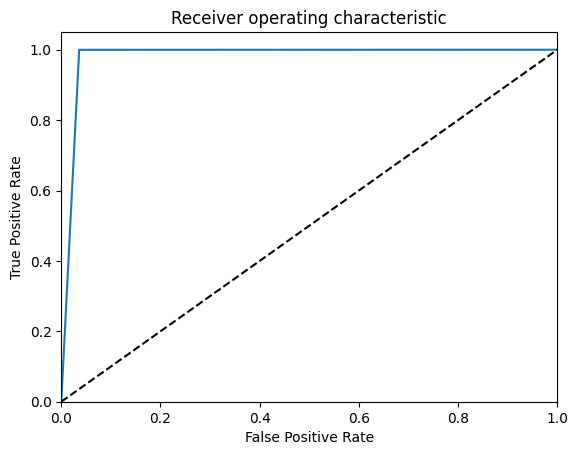

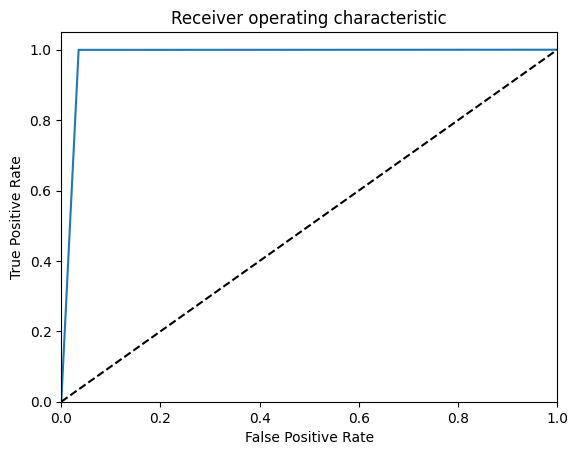

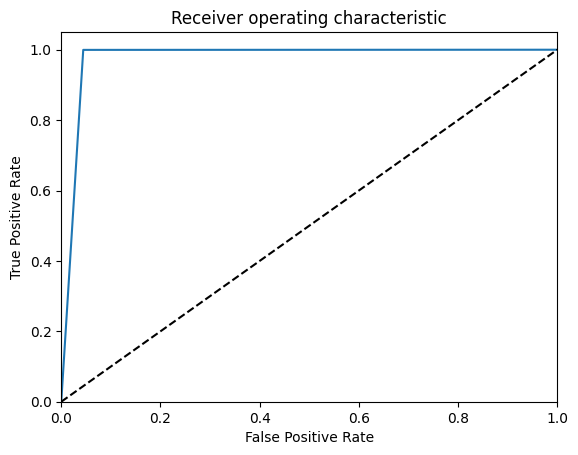

In [25]:
batch_i = 1

for train_index, test_index in strat_shuffle_split.split(X_gram_downsampled, y_downsampled):
    X_train, X_test = [X_gram_downsampled[i] for i in train_index], [X_gram_downsampled[i] for i in test_index]
    y_train, y_test = [y_downsampled[i] for i in train_index], [y_downsampled[i] for i in test_index]
    
    
    grid_lr.fit(X_train, y_train)
    print('Fit done')
    
    y_pred = grid_lr.predict(X_test)
    print('Predict done')
    
    print('Classification report:\n', classification_report(y_test, y_pred))
    
    
    # Calculate roc and auc
    roc_auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC:', roc_auc)
    
    # Roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    
    print('AUC:', auc_score)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    
    # Save
    fig.savefig(f'roc_auc_lr_all_{batch_i}.png')
    batch_i += 1
    
print('Best params:', grid_lr.best_params_)
print('Best score:', grid_lr.best_score_)
print('Best estimator:', grid_lr.best_estimator_)

## Test

In [26]:
best_lr_model = grid_lr.best_estimator_
y_pred = best_lr_model.predict(X_gram_test)

print('Classification report:\n', classification_report(y_test_2, y_pred))

# P# Print all misclassified
falses = 0
falert = 0
nonalert = 0
falerts = []
nonalerts=[]
ppp= []
qqq = []
for i in range(len(y_test_2)):
    if y_test_2[i] != y_pred[i]:
        falses += 1
        if y_pred[i] == -1:
            falert += 1
            falerts.append(X_test_2[i])
        else:
            nonalert += 1
            nonalerts.append(X_test_2[i])
        # print(f"'{X[i]}'", y[i], y_pred[i])
    if y_test_2[i] == 1 and y_pred[i] == 1:
        ppp.append(X[i])
    if y_test_2[i] == -1 and y_pred[i] == -1:
        qqq.append(X[i])
# print(falses)
alerts = len([d for d in y_test_2 if d == -1])
good = len([d for d in y_test_2 if d == 1])

print(falert)
print(good)
print(falert/good * 100)
print(len(ppp) / good * 100)
print(falerts[:10])
print('=======')
print(nonalert)
print(alerts)
print(nonalert/alerts * 100)
print(len(qqq) / alerts * 100)
print(nonalerts[:10])

Classification report:
               precision    recall  f1-score   support

          -1       1.00      0.95      0.97     10065
           1       0.98      1.00      0.99     28355

    accuracy                           0.99     38420
   macro avg       0.99      0.97      0.98     38420
weighted avg       0.99      0.99      0.99     38420

0
28355
0.0
100.0
[]
510
10065
5.067064083457526
94.93293591654248
['init.inxwizkwgixhiylsfztxu7btgqzq.base64..', '9.96pvbaxxomhlim_rlnf2efo077qg99rls47_cr7.', '11.f7hplrrrbwwtlnsaae_oucyfbjpm58r0a_vfeu.', '16.kjtjbkgj-vspbu6cbg0tkl5wb3zrd8mu8ygj29.', '35.6q79ju372srikkpxqbai608d6thccduy4gvm7q.', '44.4q5qlud6gi2jmdxqynn7pr6omnfx0rktqfsf67.', '49.wj1nzykah2c6vnuzltn5sucuuy4wnx-kjoygs-.', '52.wzyawb736q7l_j3kjhzj1bbucbqozwh8s0kyav.', '80.gh-uoxfousfhd9qxsi1en2nhnwzrqv-45k4wf8.', '127.uepgyj3ir7u-md5tsxiyu2z9yfq8wg9kuwvg9.']


## Save the model

In [27]:
with open('logisticregression_lower.pkl', 'wb') as f:
    pickle.dump(best_lr_model, f)

## Export data about the model

In [28]:
roc_auc = roc_auc_score(y_test_2, y_pred)
print(f'ROC AUC: {roc_auc}')

fpr, tpr, _ = roc_curve(y_test_2, y_pred)

roc_auc = auc(fpr, tpr)

TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test_2)):
    if y_test_2[i] == y_pred[i]:
        # True
        if y_test_2[i] == 1:
            TP += 1
        else:
            TN += 1
    else:
        # False
        if y_pred[i] == 1:
            FP += 1
        else:
            FN += 1
            
accuracy = (TP + TN)/(TP + TN + FN + FP)

precision1 = TP / (TP + FP)
precision0 = TN / (TN + FN)

recall1 = TP / (TP + FN)
recall0 = TN / (TN + FP)

f11 = 2 * (precision1 * recall1)/(precision1 + recall1)
f10 = 2 * (precision0 * recall0)/(precision0 + recall0)

all_attack = len([d for d in y_test_2 if d == -1])

lower_ae = {
    'roc_auc': roc_auc,
    'accuracy': accuracy,
    'benign':{
        'precision': precision1,
        'recall': recall1,
        'f1': f11
    },
    'attack':{
        'precision': precision0,
        'recall': recall0,
        'f1': f10
    },
    'tp': TP,
    'tn': TN,
    'fp': FP,
    'fn': FN,
    'false_alerts': FN,
    'attack_passed': (FP/all_attack) * 100
}

import json
print(json.dumps(lower_ae, indent=4))

with open('logisticregression_lower.json', 'w') as f:
    json.dump(lower_ae, f, indent=4)

ROC AUC: 0.9746646795827123
{
    "roc_auc": 0.9746646795827123,
    "accuracy": 0.9867256637168141,
    "benign": {
        "precision": 0.9823315433916507,
        "recall": 1.0,
        "f1": 0.9910870325061167
    },
    "attack": {
        "precision": 1.0,
        "recall": 0.9493293591654247,
        "f1": 0.9740061162079511
    },
    "tp": 28355,
    "tn": 9555,
    "fp": 510,
    "fn": 0,
    "false_alerts": 0,
    "attack_passed": 5.067064083457526
}
